# Movie Recommend


In [231]:
import json
import nltk
import string
import plotly
import plotly.express as px
import numpy as np
import pandas as pd
import tensorflow as tf
from ast import literal_eval
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from keras.utils import np_utils
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.metrics.pairwise import linear_kernel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [171]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Benjamin/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/Benjamin/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Read data

In [2]:
df_credits = pd.read_csv('tmdb_5000_credits.csv')
df_movies = pd.read_csv('tmdb_5000_movies.csv')

In [11]:
df_credits.shape

(4803, 4)

In [12]:
df_movies.shape

(4803, 20)

In [13]:
df_credits.head()

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [14]:
df_movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [3]:
df = df_movies.merge(df_credits, left_on='id', right_on='movie_id')

In [20]:
df.shape

(4803, 24)

In [18]:
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title_x,vote_average,vote_count,movie_id,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [22]:
vote_avg = df.vote_average.mean()
print('vote average:', vote_avg)

vote average: 6.092171559442011


In [26]:
vote_min = df['vote_count'].quantile(0.9)
# Filter out the last 10% of votes
df_available = df[df['vote_count'] > vote_min].copy()

In [53]:
df_available.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'movie_id', 'title_y', 'cast', 'crew', 'score_IMDB'],
      dtype='object')

### Calculate score
##### IMDB rating system
https://www.quora.com/How-does-IMDbs-rating-system-work  
The formula for calculating the Top Rated 250 Titles gives a true Bayesian estimate:  
weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C where:  
```
R = average for the movie (mean) = (Rating)
v = number of votes for the movie = (votes)
m = minimum votes required to be listed in the Top 250 (currently 25000)
C = the mean vote across the whole report (currently 7.0)
```
According to the above website introduction, we implemented IMDB weighted average

In [28]:
def rating_IMDB(v, m, R, C):
    return (v / (v + m)) * R + (m / (v + m)) * C

In [31]:
score_IMDB = rating_IMDB(df_available.vote_count, vote_min, df_available.vote_average, vote_avg)
df_available['score_IMDB'] = score_IMDB

In [32]:
df_available.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,status,tagline,title_x,vote_average,vote_count,movie_id,title_y,cast,crew,score_IMDB
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",7.050669
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",6.665696
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,Released,A Plan No One Escapes,Spectre,6.3,4466,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",6.239396
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",7.346721
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",6.096368


### Get highest score movie
https://www.imdb.com/chart/top?ref_=nb_mv_3_chttp
1. The Shawshank Redemption
2. The Godfather
3. The Dark Knight
4. The Godfather Part II
5. 12 Angry Men
6. Schindler's List
7. The Lord of Rings: The Return of the King
8. Plup Fiction
9. The Lord of the Rings: The Fellowship of the Ring
10. The Good, the Bad and the Ugly

In [46]:
df_available.sort_values('score_IMDB', ascending=False)[['title_x', 'release_date', 'score_IMDB', 'vote_average']].head(10)

,title_x,release_date,score_IMDB,vote_average
1881,The Shawshank Redemption,1994-09-23,8.059258,8.5
662,Fight Club,1999-10-15,7.939256,8.3
65,The Dark Knight,2008-07-16,7.920020,8.2
3232,Pulp Fiction,1994-10-08,7.904645,8.3
96,Inception,2010-07-14,7.863239,8.1
3337,The Godfather,1972-03-14,7.851236,8.4
95,Interstellar,2014-11-05,7.809479,8.1
809,Forrest Gump,1994-07-06,7.803188,8.2
329,The Lord of the Rings: The Return of the King,2003-12-01,7.727243,8.1
1990,The Empire Strikes Back,1980-05-17,7.697884,8.2


### Use TF-IDF on movie overview

In [77]:
df[df.overview.isna()]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title_x,vote_average,vote_count,movie_id,title_y,cast,crew
2656,15000000,"[{""id"": 18, ""name"": ""Drama""}]",NaN,370980,"[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",it,Chiamatemi Francesco - Il Papa della gente,NaN,0.738646,"[{""name"": ""Taodue Film"", ""id"": 45724}]",...,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,NaN,Chiamatemi Francesco - Il Papa della gente,7.3,12,370980,Chiamatemi Francesco - Il Papa della gente,"[{""cast_id"": 5, ""character"": ""Jorge Mario Berg...","[{""credit_id"": ""5660019ac3a36875f100252b"", ""de..."
4140,2,"[{""id"": 99, ""name"": ""Documentary""}]",NaN,459488,"[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",en,"To Be Frank, Sinatra at 100",NaN,0.050625,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]",...,[],Released,NaN,"To Be Frank, Sinatra at 100",0.0,0,459488,"To Be Frank, Sinatra at 100","[{""cast_id"": 0, ""character"": ""Narrator"", ""cred...","[{""credit_id"": ""592b25e4c3a368783e065a2f"", ""de..."
4431,913000,"[{""id"": 99, ""name"": ""Documentary""}]",NaN,292539,[],de,Food Chains,NaN,0.795698,[],...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,NaN,Food Chains,7.4,8,292539,Food Chains,[],"[{""credit_id"": ""5470c3b1c3a368085e000abd"", ""de..."


In [78]:
df.overview = df.overview.fillna('')

In [80]:
df[df.overview.isna()]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title_x,vote_average,vote_count,movie_id,title_y,cast,crew


In [87]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['overview'])
similar_cos = linear_kernel(tfidf_matrix, tfidf_matrix)

In [252]:
tfidf_matrix.shape

(4803, 20978)

In [132]:
a =pd.DataFrame(similar_cos[0])
a.columns=['score']

In [133]:
a

,score
0,1.000000
1,0.000000
2,0.000000
3,0.024995
4,0.000000
...,...
4798,0.000000
4799,0.000000
4800,0.000000
4801,0.000000


In [254]:
def getRecByOverview(movie_title, top=10):
    # get index
    index = df[df.title_x == movie_title].index[0]
    df_cos = pd.DataFrame(similar_cos[index])
    df_cos.columns = ['score']
    df_result = df.iloc[df_cos.sort_values(by='score', ascending=False).index][['title_x', 'overview']].copy()
    df_result['cosine_score'] = df_cos
    return df_result[: top+1]

    # return df.iloc[df_cos.sort_values(by='score', ascending=False)[:top + 1].index][['title_x']]
    

In [257]:
getRecByOverview('The Lord of the Rings: The Fellowship of the Ring')

,title_x,overview,cosine_score
262,The Lord of the Rings: The Fellowship of the Ring,"Young hobbit Frodo Baggins, after inheriting a...",1.000000
98,The Hobbit: An Unexpected Journey,"Bilbo Baggins, a hobbit enjoying his quiet lif...",0.195158
22,The Hobbit: The Desolation of Smaug,"The Dwarves, Bilbo and Gandalf have successful...",0.180959
329,The Lord of the Rings: The Return of the King,Aragorn is revealed as the heir to the ancient...,0.166745
330,The Lord of the Rings: The Two Towers,Frodo and Sam are trekking to Mordor to destro...,0.147305
1933,Underclassman,A young detective goes undercover at an elite ...,0.124586
4185,Sublime,Admitted to Mt. Abaddon Hospital for a routine...,0.119095
2344,Raging Bull,When Jake LaMotta steps into a boxing ring and...,0.117544
1616,What's the Worst That Could Happen?,Thief Kevin Caffery attempts to rob from the h...,0.117095
3714,Exiled,"A friendship is formed between an ex-gangster,...",0.112993


In [264]:
getRecByOverview('The Lord of the Rings: The Fellowship of the Ring').iloc[9].overview

'A friendship is formed between an ex-gangster, and two groups of hitmen - those who want to protect him and those who were sent to kill him.'

### title, cast, director, keywords, genres

In [4]:
# get title
df_new = pd.DataFrame()
df_new['title'] = df['title_x'].tolist()

In [5]:
# get cast

cast = []
for castList in df.cast.tolist():
    castData = json.loads(castList)
    c = []
    for cd in castData[:5]:
        c.append(cd['name'].lower().replace(' ', ''))
    if len(c) == 0:
        c = None
    cast.append(c)
    
df_new['cast'] = cast

In [6]:
# get director
director = []
for crewList in df.crew.tolist():
    crewData = json.loads(crewList)
    d = []
    for cd in crewData:
        if cd['job'] == 'Director':
            d.append(cd['name'].lower().replace(' ', ''))
    if len(d) == 0:
        d = None
    director.append(d)

df_new['director'] = director

In [7]:
# get keywords
keywords = []
for keywordsList in df.keywords.tolist():
    keywordsData = json.loads(keywordsList)
    k = []
    for kd in keywordsData[:5]:
        k.append(kd['name'].lower().replace(' ', ''))
    if len(k) == 0:
        k = None
    keywords.append(k)

df_new['keywords'] = keywords

In [8]:
# get genres
genres = []
for genresList in df.genres.tolist():
    genresData = json.loads(genresList)
    g = []
    for gd in genresData[:5]:
        g.append(gd['name'].lower().replace(' ', ''))
    if len(g) == 0:
        g = None
    genres.append(g)

df_new['genres'] = genres

In [9]:
# get overview
overviews = []
for overview in df.overview.tolist():
    stop = set(stopwords.words('english') + list(string.punctuation + '’') + ['``', "''", '""', "'s"])
    ov = str(overview).lower()
    o = [i for i in word_tokenize(ov) if i not in stop]
    if len(o) == 0:
        o = None
    overviews.append(o)

df_new['overview'] = overviews


In [10]:
# get title
titles = []
for t in df.title_x.tolist():
    stop = set(stopwords.words('english') + list(string.punctuation + '’') + ['``', "''", '""', "'s"])
    ov = str(t).lower()
    o = [i for i in word_tokenize(ov) if i not in stop]
    if len(o) == 0:
        o = None
    titles.append(o)

df_new['titles'] = titles

In [11]:
df_new = df_new.dropna()
df_new = df_new.reset_index(drop=True)


In [12]:
df_new.shape

(4363, 7)

In [13]:
df_new.head()

,title,cast,director,keywords,genres,overview,titles
0,Avatar,"[samworthington, zoesaldana, sigourneyweaver, ...",[jamescameron],"[cultureclash, future, spacewar, spacecolony, ...","[action, adventure, fantasy, sciencefiction]","[22nd, century, paraplegic, marine, dispatched...",[avatar]
1,Pirates of the Caribbean: At World's End,"[johnnydepp, orlandobloom, keiraknightley, ste...",[goreverbinski],"[ocean, drugabuse, exoticisland, eastindiatrad...","[adventure, fantasy, action]","[captain, barbossa, long, believed, dead, come...","[pirates, caribbean, world, end]"
2,Spectre,"[danielcraig, christophwaltz, léaseydoux, ralp...",[sammendes],"[spy, basedonnovel, secretagent, sequel, mi6]","[action, adventure, crime]","[cryptic, message, bond, past, sends, trail, u...",[spectre]
3,The Dark Knight Rises,"[christianbale, michaelcaine, garyoldman, anne...",[christophernolan],"[dccomics, crimefighter, terrorist, secretiden...","[action, crime, drama, thriller]","[following, death, district, attorney, harvey,...","[dark, knight, rises]"
4,John Carter,"[taylorkitsch, lynncollins, samanthamorton, wi...",[andrewstanton],"[basedonnovel, mars, medallion, spacetravel, p...","[action, adventure, sciencefiction]","[john, carter, war-weary, former, military, ca...","[john, carter]"


In [14]:
df_genres = pd.DataFrame()
df_genres['genres'] = [j for i in df_new['genres'].tolist() for j in i]
c = df_genres.value_counts()

index=[]
for i in c.index:
    index.append(np.array(i))
index=np.array(index)

df_genres=pd.DataFrame(columns=['genres','values'])
df_genres['genres']=index[:,0]
df_genres['values']=c.values

px.bar(data_frame=df_genres,x='genres',y='values', color='genres')

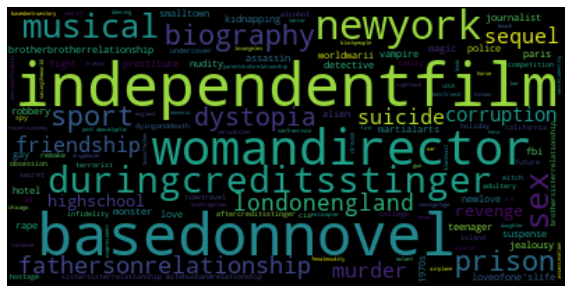

In [15]:
text=' '
for i in df_new['keywords'].tolist():
    text += ' '.join(i) +' '
    
# Make the figure
wordcloud = WordCloud().generate(text)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")

plt.show()

### Convert all features to one string

In [16]:
feature_string = [' '.join(map(str, l)) for l in (df_new.titles + df_new.cast + df_new.director + df_new.keywords + df_new.genres + df_new.overview)]

In [17]:
len(feature_string)

4363

In [18]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(feature_string)

In [19]:
count_matrix.shape

(4363, 34242)

In [20]:
feature_cos = cosine_similarity(count_matrix, count_matrix)

In [21]:
feature_cos.shape

(4363, 4363)

In [22]:
def getRecByAllData(movie_title, top=10):
    # get index
    index = df_new[df_new.title == movie_title].index[0]
    df_cos = pd.DataFrame(feature_cos[index])
    df_cos.columns = ['score']
    df_result = df_new.iloc[df_cos.sort_values(by='score', ascending=False).index][['title']].copy()
    df_result['cosine_score'] = df_cos
    return df_result[: top+1]

In [558]:
result_all_data = getRecByAllData('The Lord of the Rings: The Fellowship of the Ring')
result_all_data

,title,cosine_score
259,The Lord of the Rings: The Fellowship of the Ring,1.000000
326,The Lord of the Rings: The Two Towers,0.429560
325,The Lord of the Rings: The Return of the King,0.396438
95,The Hobbit: An Unexpected Journey,0.395130
22,The Hobbit: The Desolation of Smaug,0.339932
19,The Hobbit: The Battle of the Five Armies,0.339343
1580,What's the Worst That Could Happen?,0.195311
1407,Krull,0.147844
2264,Raging Bull,0.133352
1885,Underclassman,0.130677


In [573]:
idx = result_all_data.iloc[0].name
head_df = df_new.iloc[idx]
same_features_list = []

alias = {
    'titles': 't',
    'cast': 'c',
    'director': 'd',
    'keywords': 'k',
    'genres': 'g',
    'overview': 'o'
}

for i in range(len(result_all_data)):
    idx = result_all_data.iloc[i].name
    target_df = df_new.iloc[idx]
    features = ['titles', 'cast', 'director', 'keywords', 'genres', 'overview']
    same_features = []
    for f in features:
        feature_cnt = 0
        counted = set()
        for h in head_df[f]:
            for t in target_df[f]:
                if h == t and t not in counted:
                    counted.add(t)
                    feature_cnt += 1
        if feature_cnt != 0:
            same_features.append('%s x %d' % (f, feature_cnt))
            # same_features.append('%s x %d' % (alias[f], feature_cnt))
    print(same_features)
    same_features_list.append(', '.join(same_features))

['titles x 4', 'cast x 5', 'director x 1', 'keywords x 5', 'genres x 3', 'overview x 33']
['titles x 2', 'cast x 3', 'director x 1', 'keywords x 4', 'genres x 3', 'overview x 4']
['titles x 2', 'cast x 3', 'director x 1', 'keywords x 3', 'genres x 3', 'overview x 3']
['cast x 2', 'director x 1', 'keywords x 4', 'genres x 3', 'overview x 4']
['cast x 1', 'director x 1', 'keywords x 4', 'genres x 2', 'overview x 2']
['cast x 1', 'director x 1', 'keywords x 4', 'genres x 3', 'overview x 3']
['genres x 1', 'overview x 2']
['genres x 3', 'overview x 2']
['overview x 3']
['genres x 1', 'overview x 2']
['cast x 1', 'genres x 3', 'overview x 1']


In [574]:
result_all_data['note'] = same_features_list

In [575]:
result_all_data

,title,cosine_score,note
259,The Lord of the Rings: The Fellowship of the Ring,1.000000,"titles x 4, cast x 5, director x 1, keywords x..."
326,The Lord of the Rings: The Two Towers,0.429560,"titles x 2, cast x 3, director x 1, keywords x..."
325,The Lord of the Rings: The Return of the King,0.396438,"titles x 2, cast x 3, director x 1, keywords x..."
95,The Hobbit: An Unexpected Journey,0.395130,"cast x 2, director x 1, keywords x 4, genres x..."
22,The Hobbit: The Desolation of Smaug,0.339932,"cast x 1, director x 1, keywords x 4, genres x..."
19,The Hobbit: The Battle of the Five Armies,0.339343,"cast x 1, director x 1, keywords x 4, genres x..."
1580,What's the Worst That Could Happen?,0.195311,"genres x 1, overview x 2"
1407,Krull,0.147844,"genres x 3, overview x 2"
2264,Raging Bull,0.133352,overview x 3
1885,Underclassman,0.130677,"genres x 1, overview x 2"


In [579]:
for n in result_all_data.note.tolist():
    print(n)

titles x 4, cast x 5, director x 1, keywords x 5, genres x 3, overview x 33
titles x 2, cast x 3, director x 1, keywords x 4, genres x 3, overview x 4
titles x 2, cast x 3, director x 1, keywords x 3, genres x 3, overview x 3
cast x 2, director x 1, keywords x 4, genres x 3, overview x 4
cast x 1, director x 1, keywords x 4, genres x 2, overview x 2
cast x 1, director x 1, keywords x 4, genres x 3, overview x 3
genres x 1, overview x 2
genres x 3, overview x 2
overview x 3
genres x 1, overview x 2
cast x 1, genres x 3, overview x 1


### ML Model

##### Pre processing

In [23]:
def getSecondIndexWithoutOne(data):
    df_score = pd.DataFrame()
    df_score['score'] = data
    return df_score.sort_values(by='score', ascending=False).iloc[1].name

In [25]:
y = []
for score in feature_cos:
    y.append(getSecondIndexWithoutOne(score))

print(y[:5])


[460, 12, 1314, 65, 1233]


In [26]:
df_score = pd.DataFrame()
df_score['idx'] = y
df_score

,idx
0,460
1,12
2,1314
3,65
4,1233
...,...
4358,2539
4359,2739
4360,1663
4361,2071


In [27]:
df_score.value_counts()

idx 
1628    30
950     30
4157    29
2975    23
2175    19
        ..
1758     1
1755     1
1751     1
1743     1
4356     1
Length: 2097, dtype: int64

In [28]:
X = count_matrix
print('X shape:', X.shape)
print('y shape:', len(y))

X shape: (4363, 34242)
y shape: 4363


In [40]:
# split training, validation, testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=10)
print(len(y_train)/len(y), len(y_val)/len(y), len(y_test)/len(y))

0.799908319963328 0.10016044006417603 0.09993123997249599


## Logistic Regression

In [41]:
%%time
model_lr = LogisticRegression(random_state=10, solver='saga', max_iter=1000, verbose=True)
model_lr.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 221 epochs took 336 seconds
CPU times: user 5min 31s, sys: 3.14 s, total: 5min 34s
Wall time: 5min 37s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min finished


LogisticRegression(max_iter=1000, random_state=10, solver='saga', verbose=True)

In [42]:
print('Score for train data:', model_lr.score(X_train, y_train))
print('Score for validation data:', model_lr.score(X_val, y_val))
print('Score for test data:', model_lr.score(X_test, y_test))

Score for train data: 1.0
Score for validation data: 0.13043478260869565
Score for test data: 0.10550458715596331


## Random Forest

In [43]:
%%time
depth_list = [i * 10 for i in range(1, 10)]
acc_list_train = []
acc_list_val = []
acc_max = 0
depth_max = 0
for depth in depth_list:
    model_rf = RandomForestClassifier(random_state=10, max_depth=depth)
    model_rf.fit(X_train, y_train)
    rf_score_train = model_rf.score(X_train, y_train)
    rf_score_val = model_rf.score(X_val, y_val)
    print('depth: %d, acc of train: %f, acc of val: %f' % (depth, rf_score_train, rf_score_val))
    acc_list_train.append(rf_score_train)
    acc_list_val.append(rf_score_val)
    if rf_score_val > acc_max:
        acc_max = rf_score_val
        depth_max = depth

depth: 10, acc of train: 0.344126, acc of val: 0.064073
depth: 20, acc of train: 0.549284, acc of val: 0.057208
depth: 30, acc of train: 0.679943, acc of val: 0.070938
depth: 40, acc of train: 0.762178, acc of val: 0.066362
depth: 50, acc of train: 0.832951, acc of val: 0.070938
depth: 60, acc of train: 0.878510, acc of val: 0.075515
depth: 70, acc of train: 0.911748, acc of val: 0.080092
depth: 80, acc of train: 0.940974, acc of val: 0.073227
depth: 90, acc of train: 0.956447, acc of val: 0.080092
CPU times: user 1min 20s, sys: 6 s, total: 1min 26s
Wall time: 1min 27s


### Test sklearn model

In [133]:
def getRecBySklearnModel(movie_titles, model):
    # get index
    feature_strs = []

    for mt in movie_titles:
        index = df_new[df_new.title == mt].index[0]
        feature_strs.append(feature_string[index])
        
    data = count.transform([' '.join(feature_strs)])
    pred = model.predict(data)

    # idx = result_all_data.iloc[0].name
    head_df = df_new.iloc[pred]
    same_features_list = []

    print('Predict index: %d' % pred)
    print('Predict movie title: %s' % head_df.title.tolist()[0])

    for i in range(len(movie_titles)):
        target_df = df_new[df_new.title == movie_titles[i]]
        features = ['titles', 'cast', 'director', 'keywords', 'genres', 'overview']
        same_features = []
        for f in features:
            feature_cnt = 0
            counted = set()
            for h in head_df[f].tolist()[0]:
                for t in target_df[f].tolist()[0]:
                    if h == t and t not in counted:
                        counted.add(t)
                        feature_cnt += 1
            if feature_cnt != 0:
                same_features.append('%s x %d' % (f, feature_cnt))
        print('\nDiff with input movie "%s":' % movie_titles[i])
        print(' '.join(same_features))
        same_features_list.append(', '.join(same_features))

In [89]:
getRecBySklearnModel([
    'The Lord of the Rings: The Fellowship of the Ring',
    'The Hobbit: An Unexpected Journey',
    ], model_lr)

Predict index: 326
Predict movie title: The Lord of the Rings: The Two Towers

Diff with input movie "The Lord of the Rings: The Fellowship of the Ring":
titles x 2 cast x 3 director x 1 keywords x 4 genres x 3 overview x 4

Diff with input movie "The Hobbit: An Unexpected Journey":
cast x 1 director x 1 keywords x 3 genres x 3


In [134]:
getRecBySklearnModel(
    df_new.title.sample(n=3, random_state=10).tolist(),
    model_lr)

Predict index: 4035
Predict movie title: Love Me Tender

Diff with input movie "The Passion of the Christ":
genres x 1 overview x 1

Diff with input movie "A Madea Christmas":
genres x 1

Diff with input movie "Coal Miner's Daughter":
genres x 2


In [122]:
getRecBySklearnModel([
    'The Matrix',
    'The Matrix Reloaded',
    'Speed',
    'Point Break'
], model=model_lr)

Predict index: 120
Predict movie title: The Matrix Revolutions

Diff with input movie "The Matrix":
titles x 1 cast x 4 director x 2 keywords x 4 genres x 2

Diff with input movie "The Matrix Reloaded":
titles x 1 cast x 4 director x 2 keywords x 3 genres x 4 overview x 6

Diff with input movie "Speed":
cast x 1 genres x 2 overview x 1

Diff with input movie "Point Break":
genres x 2 overview x 1


## MLP (Multi-layer perception)

In [260]:
# encoder = LabelEncoder()
# encoder.fit([i in range(len(y))])
# encoded_y_train = encoder.transform(y_train)
dummy_y_train = np_utils.to_categorical(y_train, num_classes=len(y))
# encoded_y_val = encoder.transform(y_val)
dummy_y_val = np_utils.to_categorical(y_val, num_classes=len(y))
# encoded_y_test = encoder.transform(y_test)
dummy_y_test = np_utils.to_categorical(y_test, num_classes=len(y))

In [379]:
input_shape = (X_train.shape[1],)
num_classes = len(y)
print('input layer:', input_shape)
print('output layer:', num_classes)

input layer: (34242,)
output layer: 4363


In [369]:
model_mlp = Sequential()
model_mlp.add(Dense(512, input_shape=input_shape, activation='relu'))
model_mlp.add(Dense(64, activation='relu'))
model_mlp.add(Dense(64, activation='relu'))
model_mlp.add(Dense(512, activation='relu'))
model_mlp.add(Dense(num_classes, activation='softmax'))
# model_mlp.compile(loss='mean_absolute_error', optimizer='sgd', metrics=['accuracy'])
model_mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_mlp.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_110 (Dense)           (None, 512)               17532416  
                                                                 
 dense_111 (Dense)           (None, 64)                32832     
                                                                 
 dense_112 (Dense)           (None, 64)                4160      
                                                                 
 dense_113 (Dense)           (None, 512)               33280     
                                                                 
 dense_114 (Dense)           (None, 4363)              2238219   
                                                                 
Total params: 19,840,907
Trainable params: 19,840,907
Non-trainable params: 0
_________________________________________________________________


In [370]:
model_mlp_history = model_mlp.fit(X_train.toarray(), dummy_y_train, epochs=10, batch_size=200, verbose=1, validation_data=(X_val.toarray(), dummy_y_val))

Epoch 1/10
18/18 [==============================] - 4s 179ms/step - loss: 8.3217 - accuracy: 0.0037 - val_loss: 8.0384 - val_accuracy: 0.0046
Epoch 2/10
18/18 [==============================] - 3s 158ms/step - loss: 7.5068 - accuracy: 0.0089 - val_loss: 8.1837 - val_accuracy: 0.0069
Epoch 3/10
18/18 [==============================] - 3s 171ms/step - loss: 6.9651 - accuracy: 0.0146 - val_loss: 8.6511 - val_accuracy: 0.0160
Epoch 4/10
18/18 [==============================] - 3s 186ms/step - loss: 6.2919 - accuracy: 0.0398 - val_loss: 9.4005 - val_accuracy: 0.0137
Epoch 5/10
18/18 [==============================] - 3s 156ms/step - loss: 4.7241 - accuracy: 0.2063 - val_loss: 11.4537 - val_accuracy: 0.0275
Epoch 6/10
18/18 [==============================] - 3s 154ms/step - loss: 2.5303 - accuracy: 0.5355 - val_loss: 15.2318 - val_accuracy: 0.0206
Epoch 7/10
18/18 [==============================] - 3s 156ms/step - loss: 1.0205 - accuracy: 0.7908 - val_loss: 20.0903 - val_accuracy: 0.0183
Epo

In [340]:
test_results = model_mlp.evaluate(X_test.toarray(), dummy_y_test, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]}%')

14/14 [==============================] - 0s 17ms/step - loss: 19.8178 - accuracy: 0.0161
Test results - Loss: 19.8177547454834 - Accuracy: 0.016055045649409294%


In [326]:
model_mlp_history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

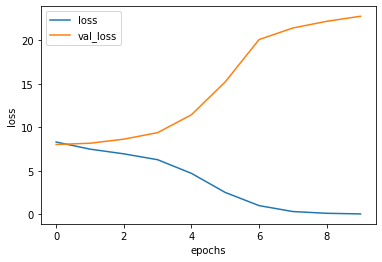

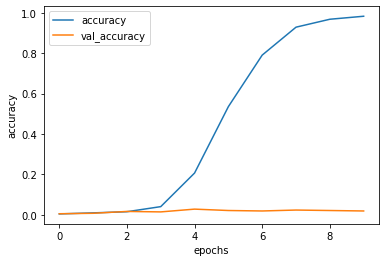

In [375]:
plt.plot(model_mlp_history.history['loss'])
plt.plot(model_mlp_history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()
plt.plot(model_mlp_history.history['accuracy'])
plt.plot(model_mlp_history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.show()

In [376]:
result_mlp = model_mlp.predict(X_train.toarray()[:])
result_mlp

array([[9.29057787e-05, 6.25610470e-22, 1.30686315e-08, ...,
        2.49065417e-36, 4.39142383e-36, 1.55755369e-36],
       [0.00000000e+00, 2.37221702e-28, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.96409356e-16, 6.72661315e-16, 1.07131880e-13, ...,
        2.36566757e-20, 4.22485608e-21, 1.85927806e-21],
       ...,
       [1.71239962e-13, 2.91173444e-13, 9.54155418e-12, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.31497785e-12, 8.93016076e-13, 6.07233863e-09, ...,
        2.00626893e-19, 1.90838723e-19, 8.46815812e-20],
       [2.47421819e-19, 2.01830878e-11, 9.76064123e-17, ...,
        1.48739901e-33, 1.63676954e-33, 1.29120046e-33]], dtype=float32)

In [377]:
print(np.argmax(result_mlp[0]), y_test[0])
print(np.argmax(result_mlp[1]), y_test[1])
print(np.argmax(result_mlp[2]), y_test[2])
print(np.argmax(result_mlp[3]), y_test[3])
print(np.argmax(result_mlp[4]), y_test[4])

2209 2433
3865 3924
3481 3109
3192 3085
689 4096


In [385]:
def getRecByMLP(movie_titles, model):
    # get index
    feature_strs = []

    for mt in movie_titles:
        index = df_new[df_new.title == mt].index[0]
        feature_strs.append(feature_string[index])
        
    data = count.transform([' '.join(feature_strs)])
    pred = model.predict(data.toarray())
    pred = np.argmax(pred)
    
    # idx = result_all_data.iloc[0].name
    head_df = df_new.iloc[pred]
    same_features_list = []

    print('Predict index: %d' % pred)
    print('Predict movie title: %s' % head_df.title)

    for i in range(len(movie_titles)):
        target_df = df_new[df_new.title == movie_titles[i]]
        features = ['titles', 'cast', 'director', 'keywords', 'genres', 'overview']
        same_features = []
        for f in features:
            feature_cnt = 0
            counted = set()
            for h in head_df[f]:
                for t in target_df[f].tolist()[0]:
                    if h == t and t not in counted:
                        counted.add(t)
                        # print(t)
                        feature_cnt += 1
            if feature_cnt != 0:
                same_features.append('%s x %d' % (f, feature_cnt))
        print('\nDiff with input movie "%s":' % movie_titles[i])
        print(' '.join(same_features))
        same_features_list.append(', '.join(same_features))

In [373]:
getRecByMLP([
    'The Lord of the Rings: The Fellowship of the Ring',
    'The Hobbit: An Unexpected Journey',
    ], model_mlp)

Predict index: 22
Predict movie title: The Hobbit: The Desolation of Smaug

Diff with input movie "The Lord of the Rings: The Fellowship of the Ring":
cast x 1 director x 1 keywords x 4 genres x 2 overview x 2

Diff with input movie "The Hobbit: An Unexpected Journey":
titles x 1 cast x 3 director x 1 keywords x 3 genres x 2 overview x 5


In [386]:
getRecByMLP(
    df_new.title.sample(n=3, random_state=10).tolist(),
    model_mlp)

Predict index: 3851
Predict movie title: Sherrybaby

Diff with input movie "The Passion of the Christ":
genres x 1 overview x 1

Diff with input movie "A Madea Christmas":
genres x 1 overview x 1

Diff with input movie "Coal Miner's Daughter":
genres x 1


In [378]:
getRecByMLP([
    'The Matrix',
    'The Matrix Reloaded',
    'Speed',
    'Point Break'
], model=model_mlp)

Predict index: 120
Predict movie title: The Matrix Revolutions

Diff with input movie "The Matrix":
titles x 1 cast x 4 director x 2 keywords x 4 genres x 2

Diff with input movie "The Matrix Reloaded":
titles x 1 cast x 4 director x 2 keywords x 3 genres x 4 overview x 6

Diff with input movie "Speed":
cast x 1 genres x 2 overview x 1

Diff with input movie "Point Break":
genres x 2 overview x 1
